In [1]:
import scipy.stats
import numpy as N
import matplotlib.pyplot as plt
from scipy.special import gamma
import numpy as np
from __future__ import division
import palettable.colorbrewer as cb

%matplotlib inline


## HRF translated from SPM

In [2]:
# this is equal to scipy.stats.gamma.pdf, but SPM has every pdf programmed
def spm_Gpdf(s,h,l):
    s = np.array(s)
    res = (h-1)*np.log(s) + h*np.log(l) - l*s - np.log(gamma(h))
    return np.exp(res)

In [3]:
def canonical(resolution):
    # translated from spm_hrf
    
    p=[6,16,1,1,6,0,32]
    dt = resolution/16.
    s = np.array(xrange(int(p[6]/dt+1)))
    #HRF sampled at 0.1 s
    hrf = spm_Gpdf(s,p[0]/p[2],dt/p[2]) - spm_Gpdf(s,p[1]/p[3],dt/p[3])/p[4]
    hrf = hrf[[int(x) for x in np.array(xrange(int(p[6]/resolution+1)))*16.]]
    hrf = hrf/np.sum(hrf)
    # duration of the HRF
    durhrf = 32.0
    # length of the HRF parameters in resolution scale
    laghrf = int(np.ceil(durhrf/resolution))
    hrf = hrf[:laghrf]

    return {"basishrf":hrf,"laghrf":laghrf}

## Comparing hrf's

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


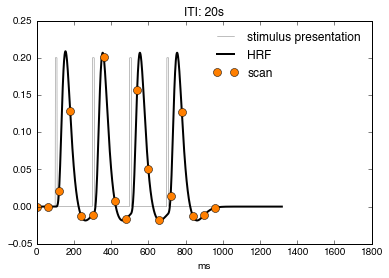

In [4]:
cols = cb.qualitative.Set1_9.mpl_colors

ts1=N.zeros(1000)
tsa = N.zeros(1000)
for dur in xrange(10):
    ts1[np.arange(100,800,200)+dur]=1
    tsa[np.arange(100,800,200)+dur]=0.2

id = np.arange(0,1000,60)

tsh1=N.convolve(ts1,canonical(0.1)['basishrf'])

plt.figure(figsize=(6,4))
plt.plot(tsa,color='grey',lw=0.5,label="stimulus presentation")
plt.plot(tsh1,color='black',lw=2,label="HRF")
plt.plot(id,tsh1[id],'o',color=cols[4],ms=8,label="scan")
plt.legend(frameon=False)
plt.xlim([0,1800])
plt.xlabel("ms")
plt.title("ITI: 20s")
plt.savefig('Efficiency.pdf',format="pdf")


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


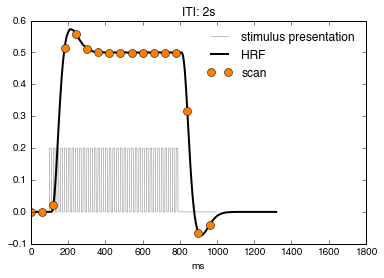

In [5]:
ts1=N.zeros(1000)
tsa = N.zeros(1000)
for dur in xrange(10):
    ts1[np.arange(100,800,20)+dur]=1
    tsa[np.arange(100,800,20)+dur]=0.2

id = np.arange(0,1000,60)

tsh1=N.convolve(ts1,canonical(0.1)['basishrf'])

plt.figure(figsize=(6,4))
plt.plot(tsa,color='grey',lw=0.5,label="stimulus presentation")
plt.plot(tsh1,color="black",lw=2,label="HRF")
plt.plot(id,tsh1[id],'o',color=cols[4],ms=8,label="scan")
plt.legend(frameon=False)
plt.xlim([0,1800])
plt.xlabel("ms")
plt.title("ITI: 2s")
plt.savefig('Power.pdf',format="pdf")


This might not be a necessary step to get the convolved signal, but it is to find the design matrix to compute estimation efficiency of a design.

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


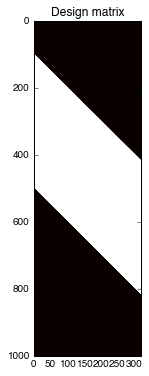

In [11]:
tp = 1000

X_X = np.zeros(tp)
X_X[100:500]=1

laghrf = int(canonical(0.1)["laghrf"])

# deconvolved matrix in resolution units
deconvM = np.zeros([tp,laghrf])
for lag in xrange(laghrf):
    deconvM[lag:,lag] = X_X[:(tp-lag)]


fig = plt.figure(figsize=(6, 6))
plt.imshow(deconvM, cmap='hot')
plt.title("Design matrix")


## Convolve signal with 3 approaches

Three approaches:
- SPM's hrf, not rescaled
- Kao's hrf, rescaled
- Kao's hrf with saturation rule

We can indeed see that with the non-rescaled approach, the signal has a maximum height of 1.  The rescaled approach goes up (and would probably go even higher with even smaller resolution).  

The third figure is their proposed solution: saturate the signal when it reached 2 times hrf height.  The signal saturates in height, but not the undershoot.  This was a problem I found as well !

In [12]:
h0 = canonical(0.1)["basishrf"]
h0_kao = canonical_kao(0.1)["basishrf"]

X_Z_Joke = np.dot(deconvM,h0)
X_Z_kao = np.dot(deconvM,h0_kao)
X_Z_saturation = [2 if x>2 else x for x in X_Z_kao]

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


(-6, 2.5)

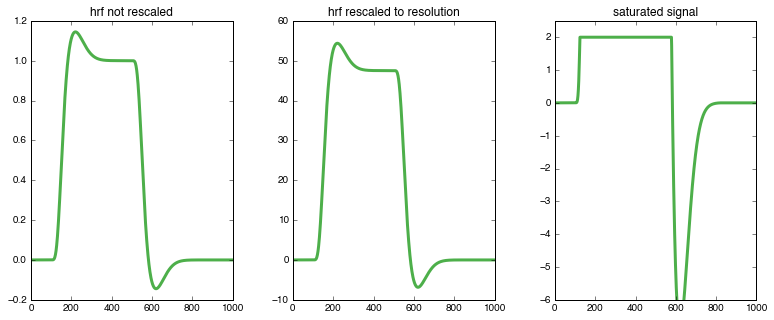

In [13]:
fig,axs=plt.subplots(1,3,figsize=(13,5))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()

axs[0].plot(X_Z_Joke,color=cols[2],lw=3)
axs[0].set_title("hrf not rescaled")
axs[1].plot(X_Z_kao,color=cols[2],lw=3)
axs[1].set_title("hrf rescaled to resolution")
axs[2].plot(X_Z_saturation,color=cols[2],lw=3)
axs[2].set_title("saturated signal")
axs[2].set_ylim([-6,2.5])

# Comparing different approaches with different durations/spacings

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


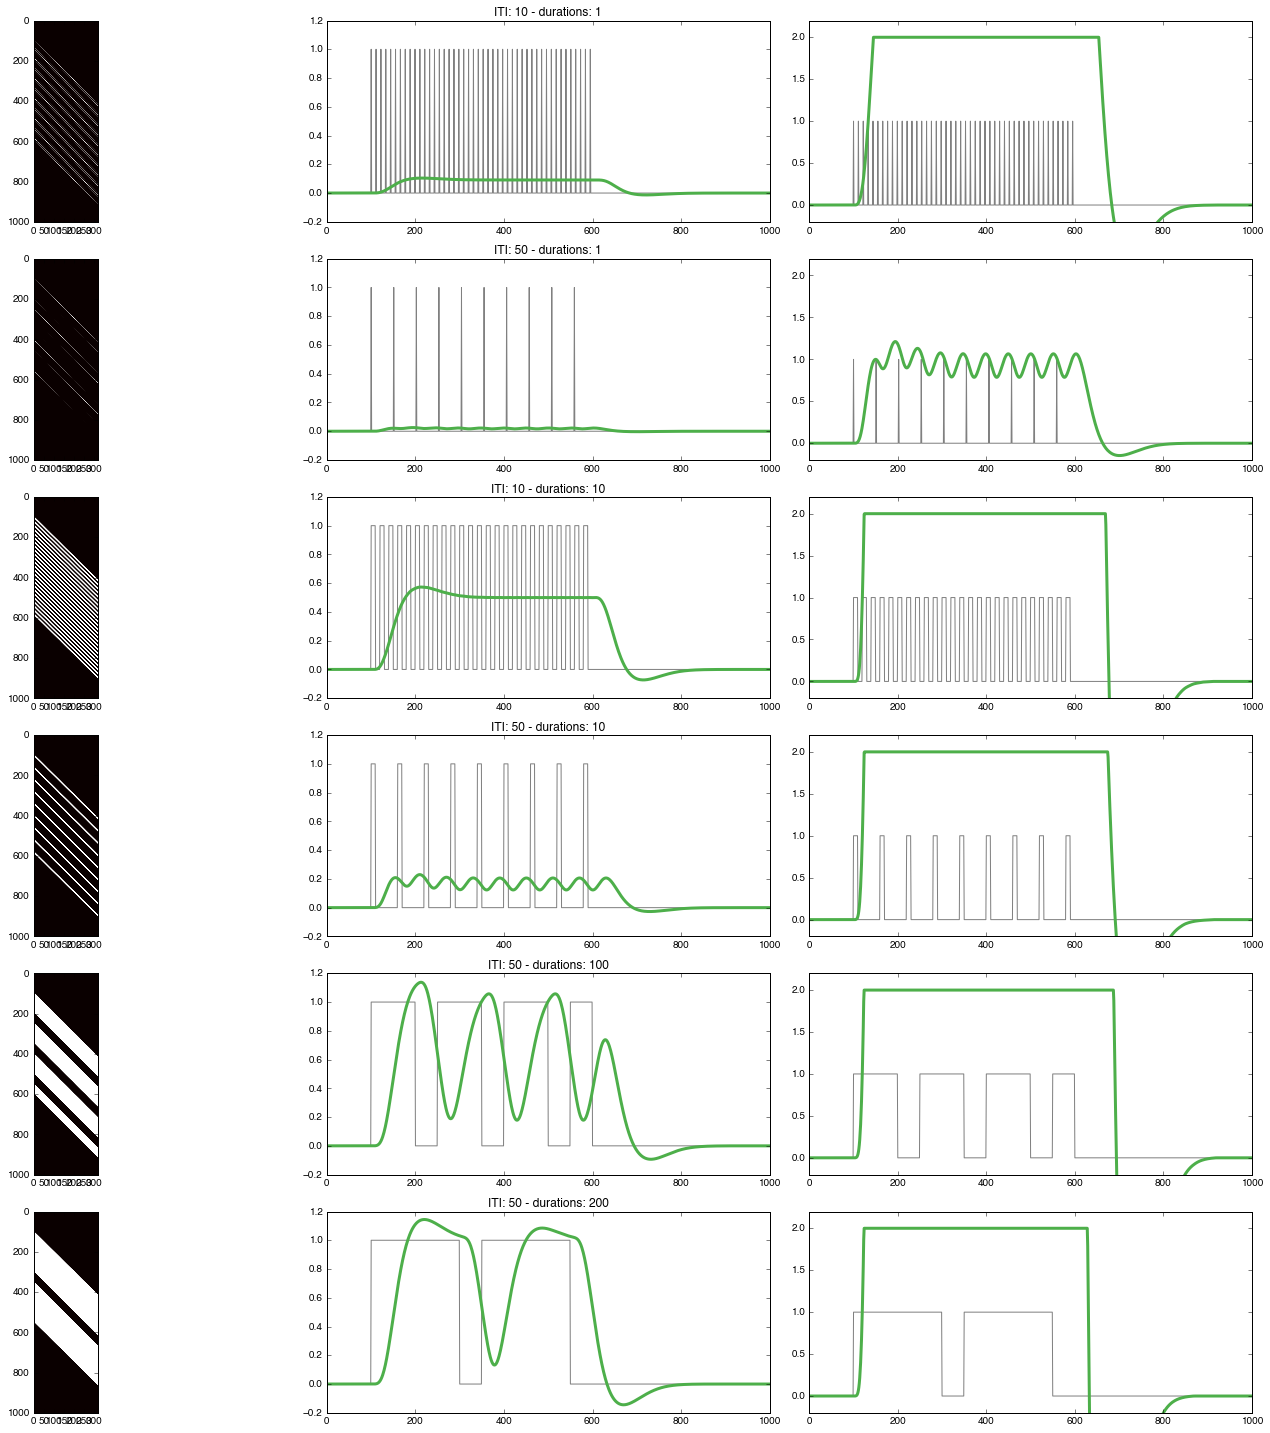

In [14]:
durations = [1,1,10,10,100,200]
spacings = [10,50,10,50,50,50]

fig,axs=plt.subplots(6,3,figsize=(20,20))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()

s = -3

for i in xrange(6):
    s = s+3

    tp = 1000
    X_X = np.zeros(tp)
    for d in xrange(durations[i]):
        X_X[np.arange(100+d,600,(spacings[i]+durations[i]))]=1

    laghrf = int(canonical(0.1)["laghrf"])

    deconvM = np.zeros([tp,laghrf])
    for lag in xrange(laghrf):
        deconvM[lag:,lag] = X_X[:(tp-lag)]

    h0 = canonical(0.1)["basishrf"]
    X_Z_Joke = np.dot(deconvM,h0)
    X_Z_kao = np.dot(deconvM,h0_kao)
    X_Z_saturation = [2 if x>2 else x for x in X_Z_kao]
    
    axs[s].imshow(deconvM,cmap='hot')
    axs[s+1].plot(X_X,color='grey',lw=1)
    axs[s+1].plot(X_Z_Joke,color=cols[2],lw=3)
    axs[s+1].set_ylim([-0.2,1.2])
    axs[s+1].set_title("ITI: "+str(spacings[i])+" - durations: "+str(durations[i]))
    axs[s+2].plot(X_X,color='grey',lw=1)
    axs[s+2].plot(X_Z_saturation,color=cols[2],lw=3)
    axs[s+2].set_ylim([-0.2,2.2])

plt.tight_layout()


## Ultimate fact check: compare standard approach with Glover's observed signal.

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


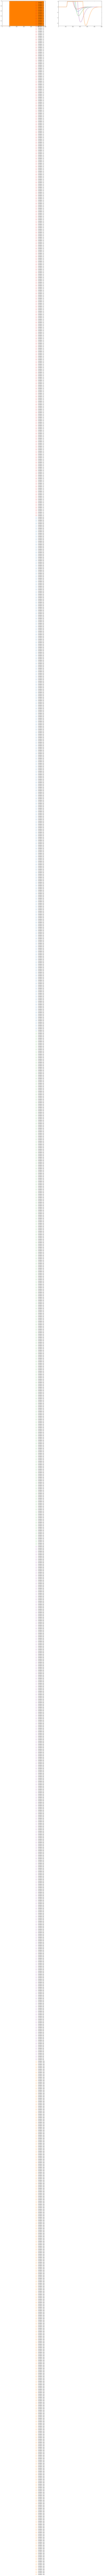

In [70]:
durations = [10,20,40,80,160]

fig,axs=plt.subplots(1,2,figsize=(20,5))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()

for i in xrange(5):

    tp = 600
    X_X = np.zeros(tp)
    for d in xrange(durations[i]):
        X_X[np.arange(100,100+d,1)]=1

    laghrf = int(canonical(0.1)["laghrf"])

    deconvM = np.zeros([tp,laghrf])
    for lag in xrange(laghrf):
        deconvM[lag:,lag] = X_X[:(tp-lag)]
 
    h0 = canonical(0.1)["basishrf"]
    X_Z_Joke = np.dot(deconvM,h0)
    X_Z_kao = np.dot(deconvM,h0_kao)
    X_Z_saturation = [2 if x>2 else x for x in X_Z_kao]
    
    axs[0].plot(deconvM,color=cols[i],lw=2,label="duration: "+str(durations[i]))
    axs[1].plot(X_Z_saturation,color=cols[i],lw=2,label="duration: "+str(durations[i]))

axs[1].set_ylim([-7,2.2])
axs[0].legend(frameon=False)



![title](glover.jpg)

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


<bound method AxesSubplot.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x14f6dbb90>>

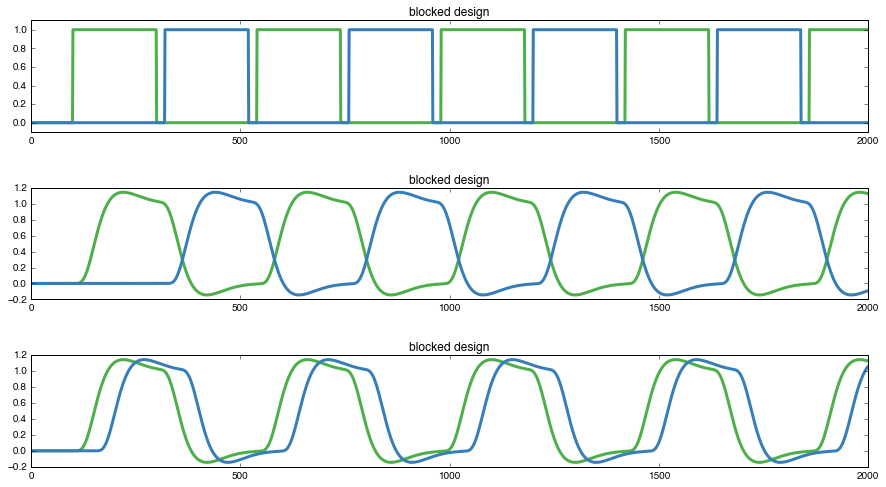

In [81]:
durations = [200]
spacings = [240]

fig,axs=plt.subplots(3,1,figsize=(15,8))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()

tp = 2000
X_X_1 = np.zeros(tp)
X_X_2 = np.zeros(tp)
X_X_3 = np.zeros(tp)
for d in xrange(durations[0]):
    X_X_1[np.arange(100+d,tp,(spacings[0]+durations[0]))]=1
    X_X_2[np.arange(320+d,tp,(spacings[0]+durations[0]))]=1
    X_X_3[np.arange(150+d,tp,(spacings[0]+durations[0]))]=1
laghrf = int(canonical(0.1)["laghrf"])

deconvM_1 = np.zeros([tp,laghrf])
deconvM_2 = np.zeros([tp,laghrf])
deconvM_3 = np.zeros([tp,laghrf])
for lag in xrange(laghrf):
    deconvM_1[lag:,lag] = X_X_1[:(tp-lag)]
    deconvM_2[lag:,lag] = X_X_2[:(tp-lag)]
    deconvM_3[lag:,lag] = X_X_3[:(tp-lag)]

h0 = canonical(0.1)["basishrf"]
X_Z_1 = np.dot(deconvM_1,h0)
X_Z_2 = np.dot(deconvM_2,h0)
X_Z_3 = np.dot(deconvM_3,h0)

axs[0].plot(X_X_1,color=cols[2],lw=3,label="seeing faces")
axs[0].plot(X_X_2,color=cols[1],lw=3,label='seeing houses')
axs[0].set_title("blocked design")
axs[0].set_ylim([-0.1,1.1])
axs[1].plot(X_Z_1,color=cols[2],lw=3)
axs[1].plot(X_Z_2,color=cols[1],lw=3)
axs[1].set_title("blocked design")
axs[2].plot(X_Z_1,color=cols[2],lw=3)
axs[2].plot(X_Z_3,color=cols[1],lw=3)
axs[2].set_title("blocked design")



/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


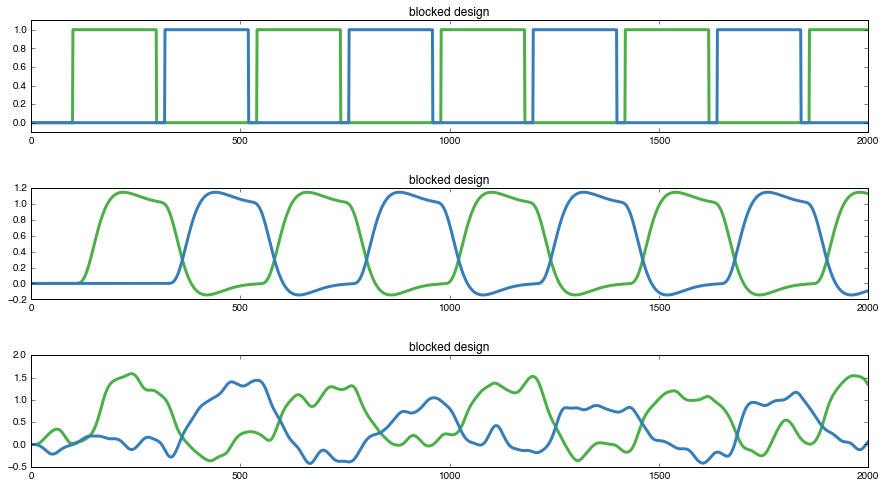

In [89]:
durations = [200]
spacings = [240]

tp = 2000
X_X_1 = np.zeros(tp)
X_X_2 = np.zeros(tp)
for d in xrange(durations[0]):
    X_X_1[np.arange(100+d,tp,(spacings[0]+durations[0]))]=1
    X_X_2[np.arange(320+d,tp,(spacings[0]+durations[0]))]=1
laghrf = int(canonical(0.1)["laghrf"])
X_X_1_noise = np.array(X_X_1)+np.random.normal(0,2,tp)
X_X_2_noise = np.array(X_X_2)+np.random.normal(0,2,tp)

deconvM_1 = np.zeros([tp,laghrf])
deconvM_2 = np.zeros([tp,laghrf])
deconvM_1_noise = np.zeros([tp,laghrf])
deconvM_2_noise = np.zeros([tp,laghrf])
for lag in xrange(laghrf):
    deconvM_1[lag:,lag] = X_X_1[:(tp-lag)]
    deconvM_2[lag:,lag] = X_X_2[:(tp-lag)]
    deconvM_1_noise[lag:,lag] = X_X_1_noise[:(tp-lag)]
    deconvM_2_noise[lag:,lag] = X_X_2_noise[:(tp-lag)]

h0 = canonical(0.1)["basishrf"]
X_Z_1 = np.dot(deconvM_1,h0)
X_Z_2 = np.dot(deconvM_2,h0)
X_Z_1_noise = np.dot(deconvM_1_noise,h0)
X_Z_2_noise = np.dot(deconvM_2_noise,h0)

fig,axs=plt.subplots(3,1,figsize=(15,8))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()

axs[0].plot(X_X_1,color=cols[2],lw=3,label="seeing faces")
axs[0].plot(X_X_2,color=cols[1],lw=3,label='seeing houses')
axs[0].set_title("blocked design")
axs[0].set_ylim([-0.1,1.1])
axs[1].plot(X_Z_1,color=cols[2],lw=3)
axs[1].plot(X_Z_2,color=cols[1],lw=3)
axs[1].set_title("blocked design")
axs[2].plot(X_Z_1_noise,color=cols[2],lw=3)
axs[2].plot(X_Z_2_noise,color=cols[1],lw=3)
axs[2].set_title("blocked design")

